<a href="https://colab.research.google.com/github/hibafathima-ts/Brain-Tumor-Prediction/blob/main/Brain_tumor_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [2]:
# Install necessary packages if needed
# !pip install opencv-python tensorflow

import numpy as np
import pandas as pd
import os
import cv2
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from scipy.io import loadmat

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_dir = '/content/drive/My Drive/Brain tumor dataset/dataset/data'
data = []
labels = []
img_size = 128  # Reduce from 224 to 128 to lower memory use

label_map = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

for file in os.listdir(data_dir):
    if file.endswith('.mat'):
        file_path = os.path.join(data_dir, file)

        try:
            # Load with scipy
            mat = loadmat(file_path)
            cjdata = mat.get('cjdata', None)
            if cjdata is None:
                raise ValueError("cjdata key not found")

            img = cjdata['image'][0, 0]
            label = int(cjdata['label'][0, 0])

        except:
            try:
                # Fallback to h5py
                with h5py.File(file_path, 'r') as mat:
                    cjdata = mat['cjdata']
                    img = np.array(cjdata['image']).T
                    label = int(np.array(cjdata['label'])[0][0])
            except Exception as e:
                print(f"Failed to load {file}: {e}")
                continue

        try:
            # Clip, resize, convert to RGB and float32
            img = np.uint8(np.clip(img, 0, 255))
            img_resized = cv2.resize(img, (img_size, img_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            img_rgb = img_rgb.astype('float32') / 255.0  # Normalize early

            data.append(img_rgb)
            labels.append(label)
        except Exception as e:
            print(f"Failed preprocessing {file}: {e}")
            continue

# Convert to NumPy arrays
X = np.array(data, dtype='float32')  # Already normalized
y = np.array(labels)

print(f"Total images loaded: {len(X)}")
print(f"Label distribution:\n{pd.Series(y).map(label_map).value_counts()}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)


Total images loaded: 3084
Label distribution:
glioma        1435
pituitary      939
meningioma     710
Name: count, dtype: int64


In [9]:
def build_custom_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_custom_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nTraining Custom CNN...")
cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop])

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10, batch_size=32,
    callbacks=[early_stop],
    verbose=1   # Ensures output is printed
)

print("\nTraining Completed..")


Training Custom CNN...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 57s 883ms/step - accuracy: 0.5833 - loss: 2.1571 - val_accuracy: 0.8623 - val_loss: 0.3695
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 856ms/step - accuracy: 0.8951 - loss: 0.2812 - val_accuracy: 0.8826 - val_loss: 0.3141
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 53s 857ms/step - accuracy: 0.9258 - loss: 0.2083 - val_accuracy: 0.8866 - val_loss: 0.3115
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 858ms/step - accuracy: 0.9493 - loss: 0.1336 - val_accuracy: 0.8968 - val_loss: 0.3078
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 845ms/step - accuracy: 0.9510 - loss: 0.1264 - val_accuracy: 0.9069 - val_loss: 0.2411
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 863ms/step - accuracy: 0.9709 - loss: 0.0888 - val_accuracy: 0.9251 - val_loss: 0.2188
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 0.9746 - loss: 0.0743 - val_accuracy: 0.9150 - val_loss: 0.2207
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 876ms/step - accuracy: 0.9847 -

In [10]:
cnn_model.save("best_cnn_model.h5")

In [11]:
!cp best_cnn_model.h5 /content/drive/MyDrive/Brain\ tumor\ prediction/

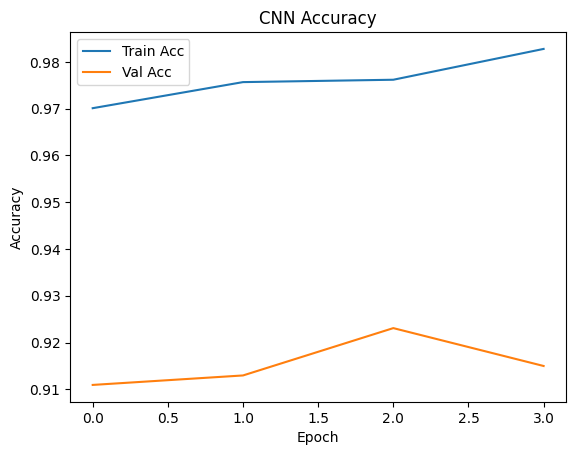

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining VGG16 Transfer Learning Model...")
vgg_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop])



Training VGG16 Transfer Learning Model...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 543s 9s/step - accuracy: 0.5771 - loss: 0.9937 - val_accuracy: 0.7794 - val_loss: 0.5020
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 563s 9s/step - accuracy: 0.7854 - loss: 0.4959 - val_accuracy: 0.8097 - val_loss: 0.4466
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 493s 8s/step - accuracy: 0.8099 - loss: 0.4368 - val_accuracy: 0.8603 - val_loss: 0.4212
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 490s 8s/step - accuracy: 0.8449 - loss: 0.3649 - val_accuracy: 0.8320 - val_loss: 0.3704
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 542s 9s/step - accuracy: 0.8540 - loss: 0.3172 - val_accuracy: 0.8745 - val_loss: 0.3152
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - accuracy: 0.8568 - loss: 0.3129 - val_accuracy: 0.8684 - val_loss: 0.3365
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 547s 9s/step - accuracy: 0.8744 - loss: 0.2614 - val_accuracy: 0.8806 - val_loss: 0.2864
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - accuracy: 0.907

In [14]:
vgg_model.save("best_vgg_model.h5")  # Save to local .h5 file
!cp best_vgg_model.h5 /content/drive/MyDrive/Brain\ tumor\ prediction/

In [15]:
print("\nApplying PCA for Random Forest...")
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=150)
X_pca = pca.fit_transform(X_flat)

X_train_pca, X_test_pca, y_train_rf, y_test_rf = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train_rf)

# Evaluation
rf_preds = rf_model.predict(X_test_pca)

print("\n--- Random Forest with PCA Evaluation ---")
print(classification_report(y_test_rf, rf_preds, target_names=[str(cls) for cls in le.classes_]))

rf_acc = accuracy_score(y_test_rf, rf_preds)
print(f"Random Forest (PCA) Accuracy: {rf_acc:.4f}")


Applying PCA for Random Forest...

--- Random Forest with PCA Evaluation ---
              precision    recall  f1-score   support

           1       0.97      0.68      0.80       142
           2       0.87      0.98      0.92       287
           3       0.94      0.98      0.96       188

    accuracy                           0.91       617
   macro avg       0.93      0.88      0.90       617
weighted avg       0.92      0.91      0.91       617

Random Forest (PCA) Accuracy: 0.9109


In [16]:
import joblib

# Save the trained RF model
joblib.dump(rf_model, "best_rf_model.pkl")

# Save the PCA transformer
joblib.dump(pca, "pca_model.pkl")

# Copy both to Google Drive
!cp best_rf_model.pkl /content/drive/MyDrive/Brain\ tumor\ prediction/
!cp pca_model.pkl /content/drive/MyDrive/Brain\ tumor\ prediction/



--- CNN Evaluation ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step
              precision    recall  f1-score   support

           1       0.84      0.79      0.81       142
           2       0.90      0.92      0.91       287
           3       0.98      0.99      0.99       188

    accuracy                           0.91       617
   macro avg       0.91      0.90      0.91       617
weighted avg       0.91      0.91      0.91       617



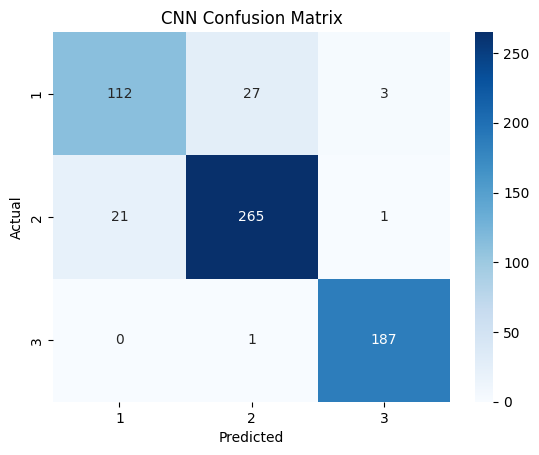


--- VGG16 Evaluation ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step
              precision    recall  f1-score   support

           1       0.85      0.75      0.80       142
           2       0.90      0.93      0.91       287
           3       0.95      0.99      0.97       188

    accuracy                           0.90       617
   macro avg       0.90      0.89      0.89       617
weighted avg       0.90      0.90      0.90       617



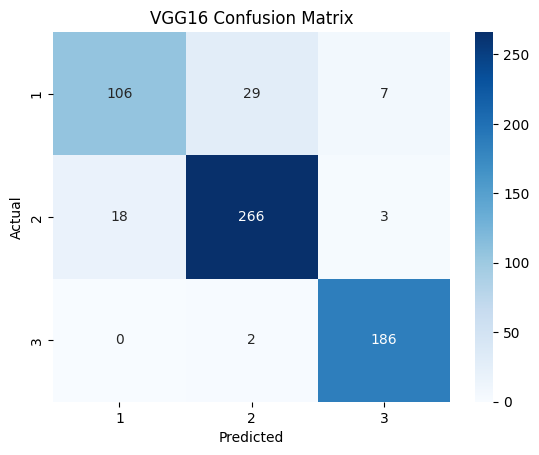


--- Random Forest with PCA Evaluation ---
              precision    recall  f1-score   support

           1       0.97      0.68      0.80       142
           2       0.87      0.98      0.92       287
           3       0.94      0.98      0.96       188

    accuracy                           0.91       617
   macro avg       0.93      0.88      0.90       617
weighted avg       0.92      0.91      0.91       617



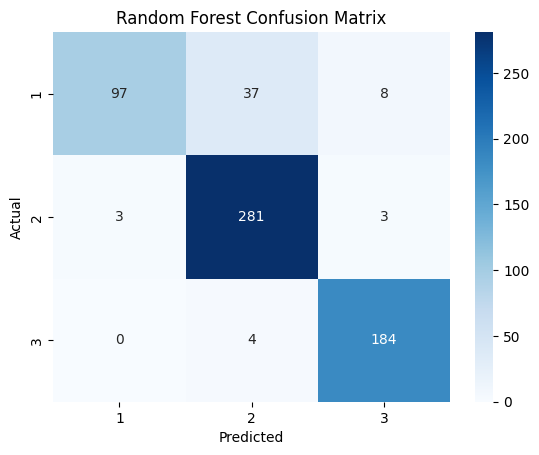

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [str(cls) for cls in le.classes_]  # Ensure string labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
# ------------------- CNN Evaluation -------------------
print("\n--- CNN Evaluation ---")
cnn_preds = cnn_model.predict(X_test)
cnn_pred_labels = np.argmax(cnn_preds, axis=1)
true_labels = np.argmax(y_test, axis=1)

print(classification_report(true_labels, cnn_pred_labels, target_names=[str(cls) for cls in le.classes_]))
plot_confusion(true_labels, cnn_pred_labels, "CNN Confusion Matrix")

# ------------------- VGG16 Evaluation -------------------
print("\n--- VGG16 Evaluation ---")
vgg_preds = vgg_model.predict(X_test)
vgg_pred_labels = np.argmax(vgg_preds, axis=1)

print(classification_report(true_labels, vgg_pred_labels, target_names=[str(cls) for cls in le.classes_]))
plot_confusion(true_labels, vgg_pred_labels, "VGG16 Confusion Matrix")

# ------------------- Random Forest Evaluation -------------------
print("\n--- Random Forest with PCA Evaluation ---")
rf_preds = rf_model.predict(X_test_pca)

print(classification_report(y_test_rf, rf_preds, target_names=[str(cls) for cls in le.classes_]))
plot_confusion(y_test_rf, rf_preds, "Random Forest Confusion Matrix")


In [18]:
cnn_acc = accuracy_score(true_labels, cnn_pred_labels)
vgg_acc = accuracy_score(true_labels, vgg_pred_labels)
rf_acc = accuracy_score(y_test_rf, rf_preds)

print("\nModel Accuracies:")
print(f"CNN Accuracy: {cnn_acc:.4f}")
print(f"VGG16 Accuracy: {vgg_acc:.4f}")
print(f"Random Forest (PCA) Accuracy: {rf_acc:.4f}")

best_model_name, best_acc = max(
    (('CNN', cnn_acc), ('VGG16', vgg_acc), ('RandomForest', rf_acc)), key=lambda x: x[1]
)
print(f"\nBest Model: {best_model_name} with accuracy {best_acc:.4f}")

# Save best model
if best_model_name == "CNN":
    cnn_model.save("best_cnn_model.h5")
elif best_model_name == "VGG16":
    vgg_model.save("best_vgg_model.h5")
else:
    joblib.dump(rf_model, "best_rf_model.pkl")



Model Accuracies:
CNN Accuracy: 0.9141
VGG16 Accuracy: 0.9044
Random Forest (PCA) Accuracy: 0.9109

Best Model: CNN with accuracy 0.9141


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
# STEP 1: Install and import necessary libraries
import numpy as np
import cv2
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import files
from PIL import Image
import io

# STEP 2: Load trained models and label map
cnn_model = load_model('best_cnn_model.h5')
vgg16_model = load_model('best_vgg_model.h5')
rf_model = joblib.load('best_rf_model.pkl')
pca = joblib.load('pca_model.pkl')

label_map = {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}

# STEP 3: Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')  # Loaded only once

# STEP 4: Preprocessing functions
def preprocess_for_cnn(image):
    image = np.array(image)
    image = cv2.resize(image, (128, 128))
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def preprocess_for_vgg16(image):
    image = image.resize((128, 128))
    image = img_to_array(image)
    image = vgg16_preprocess(image)
    return np.expand_dims(image, axis=0)

def preprocess_for_rf(image):
    image = image.resize((128, 128))
    image = img_to_array(image) / 255.0
    image = image.reshape(1, -1)
    return pca.transform(image)

# STEP 5: Make predictions
cnn_input = preprocess_for_cnn(img)
vgg_input = preprocess_for_vgg16(img)
rf_input = preprocess_for_rf(img)

cnn_probs = cnn_model.predict(cnn_input)[0]
cnn_pred = np.argmax(cnn_probs)

vgg_probs = vgg16_model.predict(vgg_input)[0]
vgg_pred = np.argmax(vgg_probs)

rf_pred = rf_model.predict(rf_input)[0]
rf_probs = rf_model.predict_proba(rf_input)[0]

# STEP 6: Display results
print("\n--- Model Predictions ---")
print(f"CNN Prediction       : {label_map[cnn_pred]} (Confidence: {cnn_probs[cnn_pred]:.2f})")
print(f"VGG16 Prediction     : {label_map[vgg_pred]} (Confidence: {vgg_probs[vgg_pred]:.2f})")
print(f"Random Forest (PCA)  : {label_map[rf_pred]} (Confidence: {rf_probs[rf_pred]:.2f})")

# STEP 7: Combine predictions using majority voting
predictions = {
    "CNN": cnn_pred,
    "VGG16": vgg_pred,
    "Random Forest": rf_pred
}

confidences = {
    "CNN": cnn_probs[cnn_pred],
    "VGG16": vgg_probs[vgg_pred],
    "Random Forest": rf_probs[rf_pred]
}

# ✅ STEP 7A: Define F1-scores from model evaluation (replace with actual values)
model_f1_scores = {
    "CNN": 0.89,          # Replace with actual F1
    "VGG16": 0.93,        # Replace with actual F1
    "Random Forest": 0.87 # Replace with actual F1
}

# STEP 8: Decision Logic
from collections import Counter
vote_counts = Counter(predictions.values())
most_common = vote_counts.most_common(1)[0]  # (class_index, count)

if most_common[1] >= 2:
    final_pred = most_common[0]
    print(f"\n✅ Final Tumor Prediction (by majority voting): {label_map[final_pred]}")
else:
    # Fallback to model with highest F1-score
    best_model = max(model_f1_scores, key=model_f1_scores.get)
    final_pred = predictions[best_model]
    print(f"\n⚠️ No majority agreement. Falling back to best model by F1-score: {best_model}")
    print(f"✅ Final Tumor Prediction: {label_map[final_pred]}")


Saving Screenshot 2025-06-12 220235.png to Screenshot 2025-06-12 220235.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step

--- Model Predictions ---
CNN Prediction       : pituitary (Confidence: 1.00)
VGG16 Prediction     : pituitary (Confidence: 1.00)
Random Forest (PCA)  : pituitary (Confidence: 0.80)

✅ Final Tumor Prediction (by majority voting): pituitary


In [33]:
!pip install streamlit
!pip install --upgrade streamlit

In [34]:
import streamlit as st
import numpy as np
import cv2
import joblib
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from collections import Counter

# Load models
cnn_model = load_model('best_cnn_model.h5')
vgg_model = load_model('best_vgg_model.h5')
rf_model = joblib.load('best_rf_model.pkl')
pca = joblib.load('pca_model.pkl')

label_map = {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}
model_f1_scores = {
    "CNN": 0.89,
    "VGG16": 0.93,
    "Random Forest": 0.87
}

# Preprocessing functions
def preprocess_for_cnn(image):
    image = np.array(image)
    image = cv2.resize(image, (128, 128))
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def preprocess_for_vgg(image):
    image = image.resize((128, 128))
    image = img_to_array(image)
    image = vgg_preprocess(image)
    return np.expand_dims(image, axis=0)

def preprocess_for_rf(image):
    image = image.resize((128, 128))
    image = img_to_array(image) / 255.0
    image = image.reshape(1, -1)
    return pca.transform(image)

# Prediction logic
def predict_tumor(image):
    cnn_input = preprocess_for_cnn(image)
    vgg_input = preprocess_for_vgg(image)
    rf_input = preprocess_for_rf(image)

    cnn_probs = cnn_model.predict(cnn_input)[0]
    vgg_probs = vgg_model.predict(vgg_input)[0]
    rf_probs = rf_model.predict_proba(rf_input)[0]

    cnn_pred = np.argmax(cnn_probs)
    vgg_pred = np.argmax(vgg_probs)
    rf_pred = rf_model.predict(rf_input)[0]

    predictions = {
        "CNN": cnn_pred,
        "VGG16": vgg_pred,
        "Random Forest": rf_pred
    }

    confidences = {
        "CNN": cnn_probs[cnn_pred],
        "VGG16": vgg_probs[vgg_pred],
        "Random Forest": rf_probs[rf_pred]
    }

    vote_counts = Counter(predictions.values())
    most_common = vote_counts.most_common(1)[0]

    if most_common[1] >= 2:
        final_pred = most_common[0]
        decision = "Majority Voting"
    else:
        best_model = max(model_f1_scores, key=model_f1_scores.get)
        final_pred = predictions[best_model]
        decision = f"Fallback to {best_model} (Highest F1-Score)"

    return {
        "final_prediction": label_map[final_pred],
        "decision_strategy": decision,
        "details": {
            "CNN": (label_map[cnn_pred], cnn_probs[cnn_pred]),
            "VGG16": (label_map[vgg_pred], vgg_probs[vgg_pred]),
            "Random Forest": (label_map[rf_pred], rf_probs[rf_pred])
        }
    }

# Streamlit UI
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain Tumor Detection & Classification")
st.markdown("Upload a brain MRI image to classify it as **Glioma**, **Meningioma**, or **Pituitary Tumor** using an ensemble of models.")

uploaded_file = st.file_uploader("Upload an MRI image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="Uploaded MRI Image", use_column_width=True)

    if st.button("Predict Tumor Type"):
        with st.spinner("Analyzing image..."):
            results = predict_tumor(image)
            st.success(f"🎯 Final Prediction: **{results['final_prediction'].upper()}**")
            st.write(f"🔍 Decision Strategy: {results['decision_strategy']}")

            st.subheader("📊 Individual Model Predictions")
            for model, (label, conf) in results["details"].items():
                st.write(f"**{model}** ➝ {label} (Confidence: {conf:.2f})")


2025-06-22 12:20:36.147 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 12:20:36.148 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 12:20:36.350 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-22 12:20:36.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 12:20:36.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 12:20:36.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 12:20:36.354 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [59]:
# 1. Install streamlit and pyngrok
!pip install streamlit pyngrok --quiet

# 2. Write your Streamlit app to a file manually
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import numpy as np
import cv2
import joblib
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from collections import Counter

# Load models
cnn_model = load_model('best_cnn_model.h5')
vgg_model = load_model('best_vgg_model.h5')
rf_model = joblib.load('best_rf_model.pkl')
pca = joblib.load('pca_model.pkl')

label_map = {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}
model_f1_scores = {
    "CNN": 0.89,
    "VGG16": 0.93,
    "Random Forest": 0.87
}

# Preprocessing functions
def preprocess_for_cnn(image):
    image = np.array(image)
    image = cv2.resize(image, (128, 128))
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def preprocess_for_vgg(image):
    image = image.resize((128, 128))
    image = img_to_array(image)
    image = vgg_preprocess(image)
    return np.expand_dims(image, axis=0)

def preprocess_for_rf(image):
    image = image.resize((128, 128))
    image = img_to_array(image) / 255.0
    image = image.reshape(1, -1)
    return pca.transform(image)

# Prediction logic
def predict_tumor(image):
    cnn_input = preprocess_for_cnn(image)
    vgg_input = preprocess_for_vgg(image)
    rf_input = preprocess_for_rf(image)

    cnn_probs = cnn_model.predict(cnn_input)[0]
    vgg_probs = vgg_model.predict(vgg_input)[0]
    rf_probs = rf_model.predict_proba(rf_input)[0]

    cnn_pred = np.argmax(cnn_probs)
    vgg_pred = np.argmax(vgg_probs)
    rf_pred = rf_model.predict(rf_input)[0]

    predictions = {
        "CNN": cnn_pred,
        "VGG16": vgg_pred,
        "Random Forest": rf_pred
    }

    confidences = {
        "CNN": cnn_probs[cnn_pred],
        "VGG16": vgg_probs[vgg_pred],
        "Random Forest": rf_probs[rf_pred]
    }

    vote_counts = Counter(predictions.values())
    most_common = vote_counts.most_common(1)[0]

    if most_common[1] >= 2:
        final_pred = most_common[0]
        decision = "Majority Voting"
    else:
        best_model = max(model_f1_scores, key=model_f1_scores.get)
        final_pred = predictions[best_model]
        decision = f"Fallback to {best_model} (Highest F1-Score)"

    return {
        "final_prediction": label_map[final_pred],
        "decision_strategy": decision,
        "details": {
            "CNN": (label_map[cnn_pred], cnn_probs[cnn_pred]),
            "VGG16": (label_map[vgg_pred], vgg_probs[vgg_pred]),
            "Random Forest": (label_map[rf_pred], rf_probs[rf_pred])
        }
    }

# Streamlit UI
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain Tumor Detection & Classification")
st.markdown("Upload a brain MRI image to classify it as **Glioma**, **Meningioma**, or **Pituitary Tumor** using an ensemble of models.")

uploaded_file = st.file_uploader("Upload an MRI image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="Uploaded MRI Image", use_column_width=True)

    if st.button("Predict Tumor Type"):
        with st.spinner("Analyzing image..."):
            results = predict_tumor(image)
            st.success(f"🎯 Final Prediction: **{results['final_prediction'].upper()}**")
            st.write(f"🔍 Decision Strategy: {results['decision_strategy']}")

            st.subheader("📊 Individual Model Predictions")
            for model, (label, conf) in results["details"].items():
                st.write(f"**{model}** ➝ {label} (Confidence: {conf:.2f})")
""")

# 3. Start Streamlit in background
import subprocess
import time
process = subprocess.Popen(["streamlit", "run", "app.py"])
time.sleep(5)  # wait for server to start

from pyngrok import ngrok
ngrok.kill()  # kill any existing tunnels

public_url = ngrok.connect(addr="8501", proto="http")
print("✅ App is live at:", public_url)


✅ App is live at: NgrokTunnel: "https://9c7d-35-194-176-209.ngrok-free.app" -> "http://localhost:8501"
